# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

# IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN

In [1]:
# Librerías de ciencia de datos y manipulación de datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2

# TensorFlow y Keras para construir y entrenar redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from keras import regularizers

# Métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Carga de datos desde Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soledadmurias","key":"ff4c8dfdc48ed1373ed1e483b6e0cf9e"}'}

In [3]:
# Configuración de Kaggle para descargar datos
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset
!unzip -qq yoga-posture-dataset.zip -d my_dataset

Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
 97% 432M/447M [00:02<00:00, 178MB/s]
100% 447M/447M [00:02<00:00, 201MB/s]


# CARGA Y PREPARACIÓN DE LOS DATOS

In [4]:
# Definir el directorio de imágenes descargadas
image_dir = Path("my_dataset/yoga_posture")

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir

--2024-11-10 12:32:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-10 12:32:13 (95.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
dataset = "my_dataset"
walk_through_dir(dataset)

image_dir = Path(dataset)

There are 47 directories and 1 images in 'my_dataset'.
There are 0 directories and 59 images in 'my_dataset/Ardha Chandrasana'.
There are 0 directories and 54 images in 'my_dataset/Dhanurasana'.
There are 0 directories and 43 images in 'my_dataset/Pincha Mayurasana'.
There are 0 directories and 23 images in 'my_dataset/Trikonasana'.
There are 0 directories and 53 images in 'my_dataset/Eka Pada Rajakapotasana'.
There are 0 directories and 61 images in 'my_dataset/Virabhadrasana Two'.
There are 0 directories and 20 images in 'my_dataset/Sivasana'.
There are 0 directories and 81 images in 'my_dataset/Utkatasana'.
There are 0 directories and 85 images in 'my_dataset/Garudasana'.
There are 0 directories and 81 images in 'my_dataset/Baddha Konasana'.
There are 0 directories and 62 images in 'my_dataset/Salamba Bhujangasana'.
There are 0 directories and 71 images in 'my_dataset/Halasana'.
There are 0 directories and 64 images in 'my_dataset/Utthita Hasta Padangusthasana'.
There are 0 director

In [6]:
# Obtener ruta de cada imagen y etiqueta
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
unique_labels = len(np.unique(labels))
print("El número de etiquetas únicos es: "+str(unique_labels))

# Si bien el directorio tiene 47 carpetas, las etiquetas únicas son 43. Esto indica que hay nombre de carpetas duplicados.

El número de etiquetas únicos es: 43


In [7]:
filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatener ruta y etiqueta
image_df = pd.concat([filepaths, labels], axis = 1)

image_df

,Filepath,Label
0,my_dataset/Utkatasana/File42.jpg,Utkatasana
1,my_dataset/Utkatasana/File68.jpg,Utkatasana
2,my_dataset/Baddha Konasana/File59.jpg,Baddha Konasana
3,my_dataset/Baddha Konasana/File21.jpg,Baddha Konasana
4,my_dataset/Baddha Konasana/File49.jpg,Baddha Konasana
...,...,...
4664,my_dataset/Alanasana/File13.png,Alanasana
4665,my_dataset/Alanasana/File2.png,Alanasana
4666,my_dataset/Alanasana/File18.png,Alanasana
4667,my_dataset/Alanasana/File11.png,Alanasana


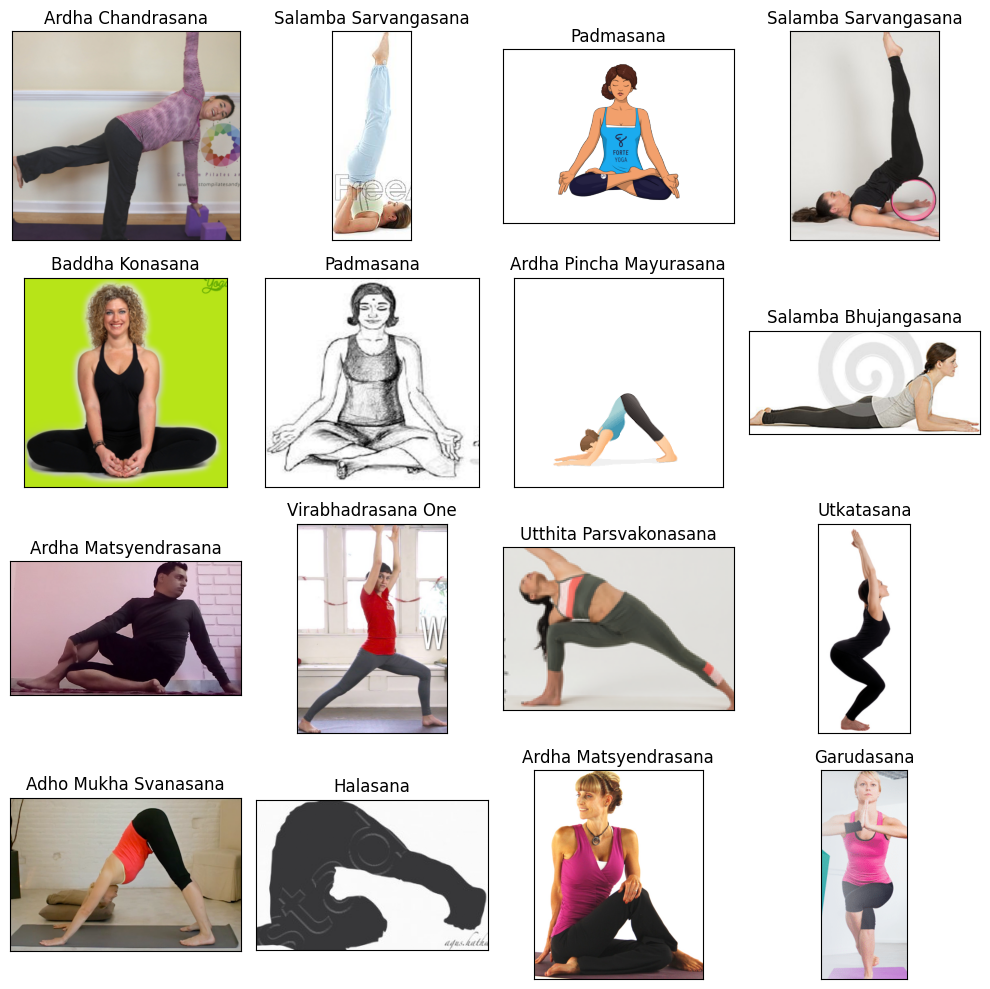

In [8]:
# Mostramos 16 imagenes a modelo de ejemplo con su respectiva categoría
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10, 10),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
# Crear un DataFrame con las rutas y etiquetas para fácil manipulación
image_df = pd.DataFrame({"Filepath": filepaths, "Label": labels})

In [10]:
# Separación en datos de entrenamiento y prueba (80% para entrenamiento y 20% para prueba)
train_df, test_df = train_test_split(image_df, test_size=0.2, stratify=labels, random_state=42)

# CONFIGURACIÓN DE GENERADORES DE IMÁGENES

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,  # 20% de datos de entrenamiento reservados para validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    directory='my_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


# Generador de datos de prueba (solo preprocesamiento, sin aumentación)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

validation_generator = train_datagen.flow_from_directory(
    directory='my_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 2227 images belonging to 47 classes.
Found 529 images belonging to 47 classes.


In [12]:
# Generadores de imágenes de entrenamiento, validación y prueba
train_images = train_datagen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=True, seed=42, subset="training"
)

val_images = train_datagen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=True, seed=42, subset="validation"
)

test_images = test_datagen.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=False
)

Found 2988 validated image filenames belonging to 43 classes.
Found 747 validated image filenames belonging to 43 classes.
Found 934 validated image filenames belonging to 43 classes.


# ESTRATEGIA 1: ENTRENAR DESDE CERO

## ARQUITECTURA DEL MODELO CNN

In [13]:
# Definir el número de clases a partir de los datos de entrenamiento
num_classes = len(train_images.class_indices)

# Arquitectura del modelo usando Keras Sequential
model = Sequential([
    # Primera capa de convolución
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.1),

    # Segunda capa de convolución
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    # Tercera capa de convolución
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    # Cuarta capa de convolución adicional
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    # Capa fully connected
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),

    # Capa de salida
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1.  Tamaño de Filtros: Los filtros (3,3) son generalmente óptimos para detectar bordes y patrones en imágenes de tamaño medio.
Batch Normalization y Dropout: Juntos, combaten el sobreajuste y estabilizan el aprendizaje.
2.  Learning Rate (Adam): Comenzamos con 0.001, pero este parámetro se puede ajustar con experimentación en futuras pruebas si el modelo muestra un aprendizaje lento o inestable.
3.  Esta arquitectura y los hiperparámetros permiten una buena generalización al evitar el sobreajuste y aprender patrones profundos en las imágenes de posturas de yoga.

4.   Capas de convolución: Tres capas de convolución permiten a la red capturar patrones complejos y profundos de las imágenes.
5.   MaxPooling: La reducción de dimensionalidad ayuda a reducir la carga computacional y a captar características invariantes a traslaciones.
6.   Regularización y dropout: Usamos l2 y dropout en cada capa para reducir el sobreajuste. l2 penaliza los pesos excesivamente altos, mientras que el dropout apaga neuronas aleatorias para forzar a la red a ser más robusta.
7.   Batch Normalization: Acelera la convergencia y mejora la estabilidad del entrenamiento.

In [14]:
# Resumen del modelo para ver la estructura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,115,115 (19.51 MB)

 Trainable params: 5,113,899 (19.51 MB)

 Non-trainable params: 1,216 (4.75 KB)

## COMPILACIÓN Y OPTIMIZACIÓN DEL MODELO

In [15]:
# Compilación del modelo con optimizador Adam y función de pérdida categórica
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir callbacks para control del entrenamiento
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

In [16]:
# Entrenamiento del modelo usando los generadores de datos
history = model.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20241110-123218
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 80s 760ms/step - accuracy: 0.0307 - loss: 4.8131 - val_accuracy: 0.0176 - val_loss: 4.1246
Epoch 2/100
25/69 ━━━━━━━━━━━━━━━━━━━━ 14s 320ms/step - accuracy: 0.0690 - loss: 4.1739

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.0626 - loss: 4.1923 - val_accuracy: 0.0128 - val_loss: 4.0963
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 88s 689ms/step - accuracy: 0.0777 - loss: 4.0089 - val_accuracy: 0.0430 - val_loss: 4.3824
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.0947 - loss: 3.8623 - val_accuracy: 0.0128 - val_loss: 4.4333
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 52s 714ms/step - accuracy: 0.1233 - loss: 3.7496 - val_accuracy: 0.0488 - val_loss: 3.9555
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.1179 - loss: 3.5937 - val_accuracy: 0.0511 - val_loss: 4.0450
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 648ms/step - accuracy: 0.1550 - loss: 3.4668 - val_accuracy: 0.0996 - val_loss: 3.7774
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.1732 - loss: 3.3372 - val_accuracy: 0.1362 - val_loss: 3.5540
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 57s 786ms/step - accuracy: 0.1750 - loss: 3.2743 - val_accuracy

## EVALUACIÓN DEL MODELO


El conjunto de datos de prueba se utilizará para evaluar el rendimiento del modelo. Una de las métricas que se probará es la precisión, que mide la fracción de predicciones correctas realizadas por el modelo. Otras métricas son las siguientes:

* **Precisión (P)**: La fracción de verdaderos positivos (TP, predicciones correctas) sobre el total de resultados relevantes, es decir, la suma de TP y falsos positivos (FP). En problemas de clasificación multiclase, la precisión se promedia entre las clases. La fórmula para la precisión es la siguiente.
$$P = \frac{TP}{TP+FP}$$

* **Recall (R)**: La fracción de verdaderos positivos (TP) sobre el total de TP y falsos negativos (FN). En problemas de clasificación multiclase, la exhaustividad se promedia entre todas las clases. La fórmula para el recall es la siguiente.
$$R = \frac{TP}{TP+FN}$$

* **F1 Score (F1)**: La media armónica de la precisión y la exhaustividad. En problemas de clasificación multiclase, F1 se promedia entre todas las clases. La fórmula para la puntuación F1 es la siguiente.
$$F1 = \frac{2*TP*FP}{TP+FP}$$

In [17]:
# Evaluación en el conjunto de prueba
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 1.61873
Test Accuracy: 72.38%


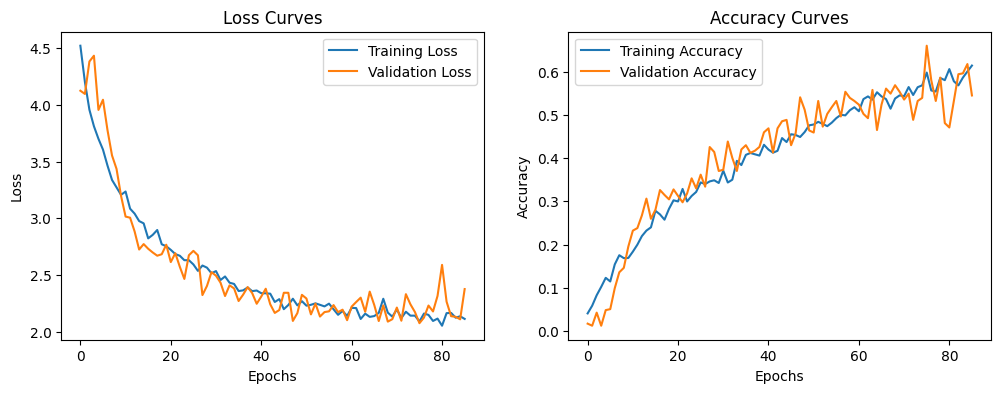

In [18]:
# Función para graficar las curvas de precisión y pérdida
def plot_loss_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()

# Llamar a la función para graficar
plot_loss_curves(history)

In [19]:
# Predicción en el conjunto de prueba
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_images.classes

# Imprimir informe de clasificación
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.74      0.82      0.78        28
         Adho Mukha Vrksasana       0.56      0.42      0.48        24
                    Alanasana       0.33      0.50      0.40         2
                 Anjaneyasana       0.53      0.76      0.62        25
            Ardha Chandrasana       0.87      0.65      0.74        20
         Ardha Matsyendrasana       0.81      0.72      0.76        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       0.42      0.80      0.55        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.86      0.64      0.73        28
                     Bakasana       0.70      0.61      0.66        31
                     Balasana       0.63      0.86      0.73        28
                   Bitilasana      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


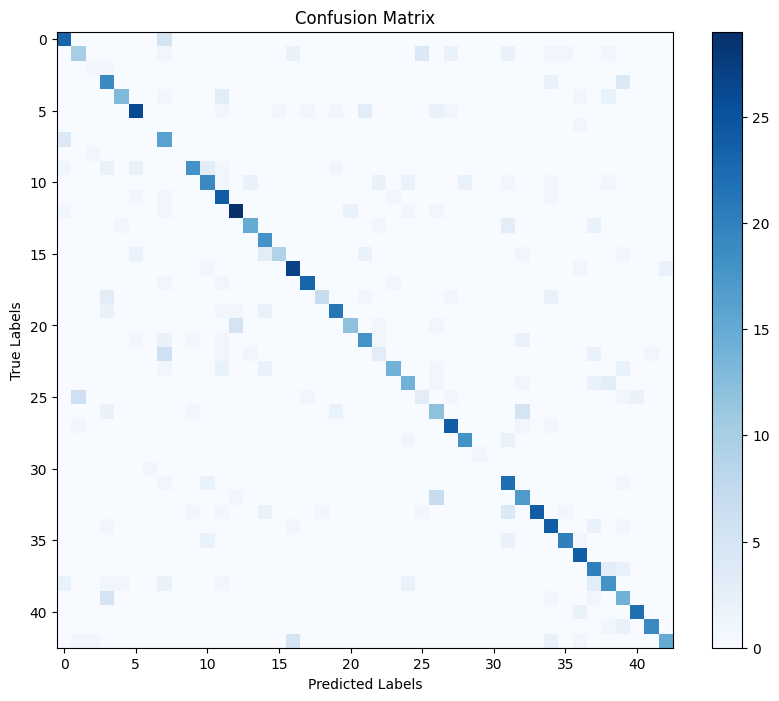

In [20]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

# ESTRATEGIA 2: MODELOS PREENTRENADOS

## MOBILENETV*

### CARGA DEL MODELO

In [21]:
# Cargar el modelo base MobileNetV2 preentrenado
from tensorflow.keras.applications import MobileNetV2

base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model1.trainable = False  # Congelar el modelo base para el primer


# Construir las capas adicionales para la clasificación
x = base_model1.output
x = layers.Flatten()(x)  # Utilizar Flatten para conservar toda la información espacial
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(unique_labels, activation='softmax')(x)

# Crear el modelo completo
model1 = Model(inputs=base_model1.input, outputs=predictions)

# Compilar el modelo con una tasa de aprendizaje inicial
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento inicial (solo las capas añadidas)
history_aug1 = model1.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving TensorBoard log files to: training_logs/yoga_classification/20241110-132749


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 831ms/step - accuracy: 0.1816 - loss: 3.6491 - val_accuracy: 0.4531 - val_loss: 2.4249
Epoch 2/100
24/69 ━━━━━━━━━━━━━━━━━━━━ 16s 371ms/step - accuracy: 0.4519 - loss: 2.1421

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 439ms/step - accuracy: 0.4841 - loss: 2.0188 - val_accuracy: 0.5362 - val_loss: 1.6942
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 796ms/step - accuracy: 0.5886 - loss: 1.6318 - val_accuracy: 0.5742 - val_loss: 1.5460
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.6559 - loss: 1.4504 - val_accuracy: 0.6255 - val_loss: 1.3385
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 56s 772ms/step - accuracy: 0.7190 - loss: 1.1848 - val_accuracy: 0.6934 - val_loss: 1.2189
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.7287 - loss: 1.1468 - val_accuracy: 0.6979 - val_loss: 1.2436
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 619ms/step - accuracy: 0.7657 - loss: 1.0238 - val_accuracy: 0.7285 - val_loss: 1.1017
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.7726 - loss: 1.0035 - val_accuracy: 0.7191 - val_loss: 1.1600
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 729ms/step - accuracy: 0.8128 - loss: 0.9141 - val_accuracy

### EVALUACIÓN DEL MODELO

In [22]:
# Evaluación en Transfer Learning
results_transfer1 = model1.evaluate(test_images, verbose=0)
print("    Test Loss (Transfer Learning): {:.5f}".format(results_transfer1[0]))
print("Test Accuracy (Transfer Learning): {:.2f}%".format(results_transfer1[1] * 100))

# Predicción y reporte de clasificación
predictions_transfer1 = model1.predict(test_images, batch_size=128)
print("Reporte de Clasificación - Transfer Learning:")
print(classification_report(test_images.classes, predictions_transfer1.argmax(axis=1), target_names=test_images.class_indices.keys()))

    Test Loss (Transfer Learning): 0.91396
Test Accuracy (Transfer Learning): 88.76%
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step
Reporte de Clasificación - Transfer Learning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.75      0.96      0.84        28
         Adho Mukha Vrksasana       0.95      0.88      0.91        24
                    Alanasana       0.67      1.00      0.80         2
                 Anjaneyasana       0.86      0.76      0.81        25
            Ardha Chandrasana       1.00      0.95      0.97        20
         Ardha Matsyendrasana       0.81      0.94      0.87        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       0.94      0.85      0.89        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.93      0.93      0.93        28
                     Bakasana       0.97     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


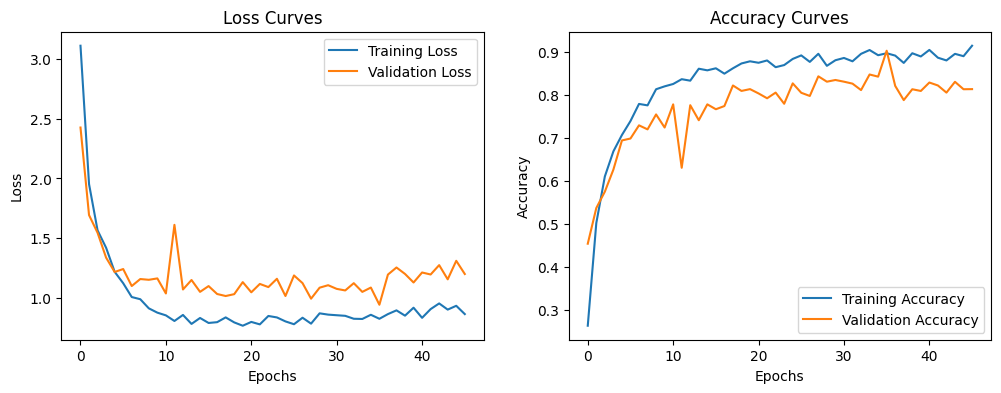

In [23]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plot_loss_curves(history_aug1)

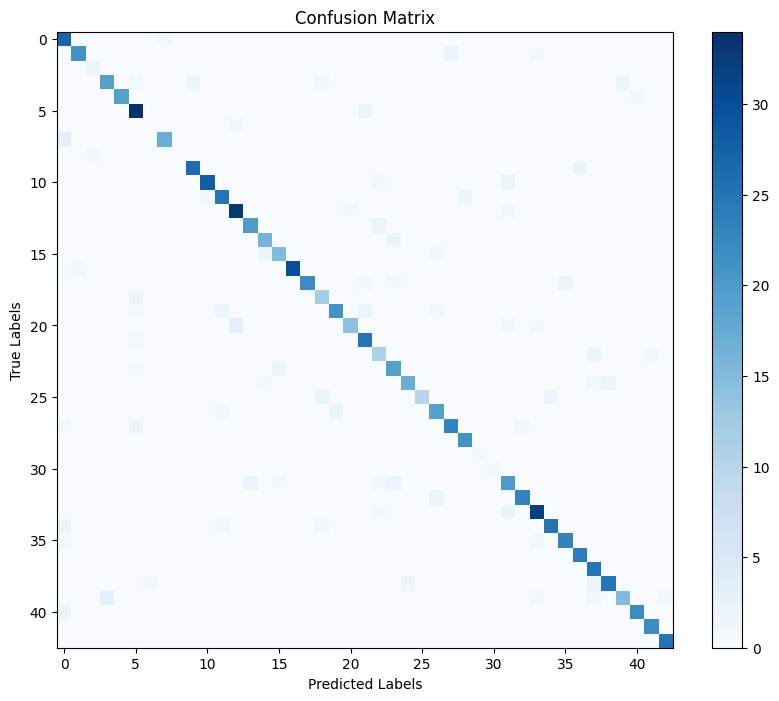

In [32]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, predictions_transfer1.argmax(axis=1))
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

### FINE TUNNING DEL MODELO

In [24]:
# Descongelar parcialmente el modelo base
fine_tune_at = 120  # Descongelar capas a partir de la capa 120

for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False
base_model1.trainable = True

# Compilar el modelo nuevamente con una tasa de aprendizaje menor
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_fine1 = model1.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20241110-135513


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.6872 - loss: 1.5933 - val_accuracy: 0.8340 - val_loss: 1.0822
Epoch 2/100
25/69 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - accuracy: 0.8022 - loss: 1.0853

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.8008 - loss: 1.0950 - val_accuracy: 0.7872 - val_loss: 1.3182
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 84s 749ms/step - accuracy: 0.8443 - loss: 1.0081 - val_accuracy: 0.7988 - val_loss: 1.3083
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.8385 - loss: 0.9733 - val_accuracy: 0.7787 - val_loss: 1.3834
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 51s 701ms/step - accuracy: 0.8728 - loss: 0.8519 - val_accuracy: 0.8457 - val_loss: 1.1555
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.9104 - loss: 0.7995 - val_accuracy: 0.8340 - val_loss: 1.0747
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 49s 663ms/step - accuracy: 0.9025 - loss: 0.7774 - val_accuracy: 0.8398 - val_loss: 1.1652
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.9176 - loss: 0.7422 - val_accuracy: 0.8809 - val_loss: 1.0338
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 657ms/step - accuracy: 0.9238 - loss: 0.7157 - val_accuracy

In [25]:
# Evaluación en Fine-Tuning
results_fine_tuning1 = model1.evaluate(test_images, verbose=0)
print("    Test Loss (Fine-Tuning): {:.5f}".format(results_fine_tuning1[0]))
print("Test Accuracy (Fine-Tuning): {:.2f}%".format(results_fine_tuning1[1] * 100))

# Predicción y reporte de clasificación en Fine-Tuning
predictions_fine = model1.predict(test_images, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning:")
print(classification_report(test_images.classes, predictions_fine.argmax(axis=1), target_names=test_images.class_indices.keys()))


    Test Loss (Fine-Tuning): 0.95629
Test Accuracy (Fine-Tuning): 88.12%
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step
Reporte de Clasificación - Fine-Tuning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.65      1.00      0.79        28
         Adho Mukha Vrksasana       0.95      0.75      0.84        24
                    Alanasana       0.67      1.00      0.80         2
                 Anjaneyasana       0.83      0.76      0.79        25
            Ardha Chandrasana       1.00      0.95      0.97        20
         Ardha Matsyendrasana       0.88      0.97      0.92        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       1.00      0.75      0.86        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.80      1.00      0.89        28
                     Bakasana       1.00      0.87      0.93   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


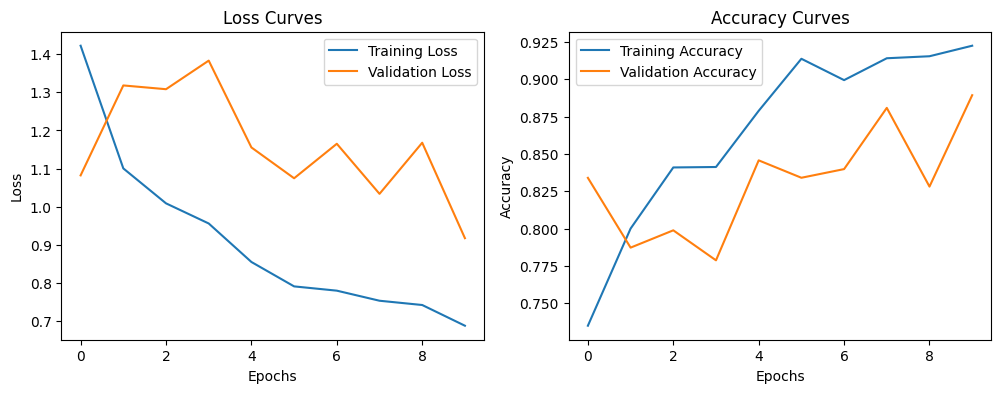

In [26]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plot_loss_curves(history_fine1)

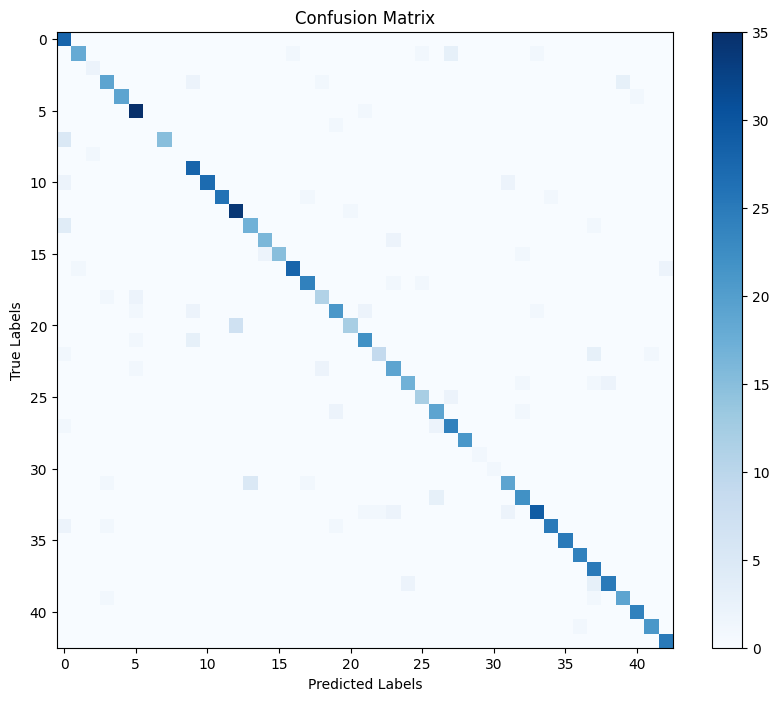

In [33]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, predictions_fine.argmax(axis=1))
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

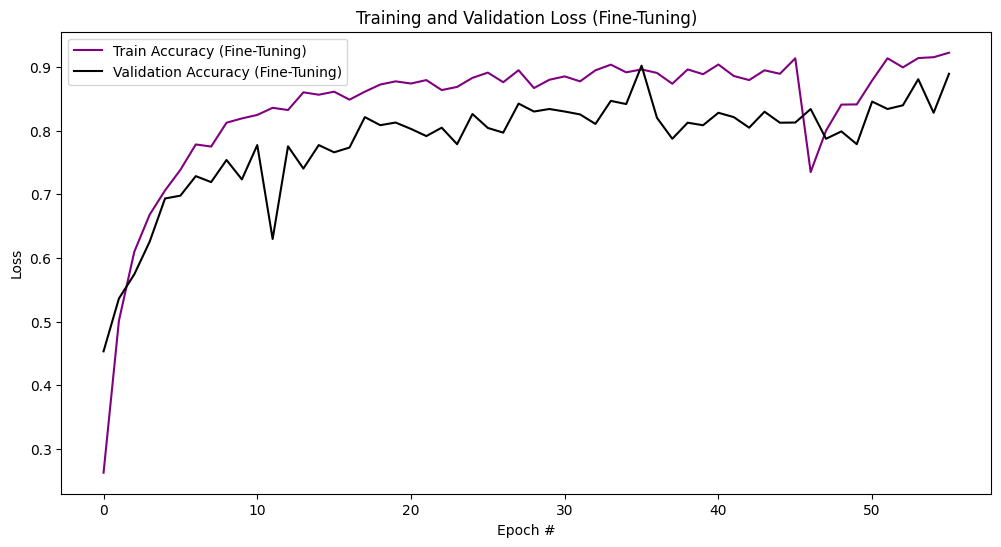

In [27]:
# Graficar Accuracy de entrenamiento y validación de Fine-Tuning
acc = history_aug1.history['accuracy'] + history_fine1.history['accuracy']
val_acc = history_aug1.history['val_accuracy'] + history_fine1.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(range(len(acc)), acc, label='Train Accuracy (Fine-Tuning)', color='purple')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy (Fine-Tuning)', color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

## INCEPTIONV3

### CARGA DEL MODELO

In [30]:
# Cargar el modelo base InceptionV3 preentrenado
from tensorflow.keras.applications import InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = inception_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
inception_predictions = layers.Dense(unique_labels, activation='softmax')(x)

# Crear el modelo completo
inception_model = Model(inputs=inception_base.input, outputs=inception_predictions)

# Compilamos el modelo
inception_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Entrenamiento inicial
inception_history = inception_model.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20241110-141440
Epoch 1/100
 9/69 ━━━━━━━━━━━━━━━━━━━━ 25s 431ms/step - accuracy: 0.0476 - loss: 5.0053

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 830ms/step - accuracy: 0.1269 - loss: 4.0327 - val_accuracy: 0.2832 - val_loss: 3.0612
Epoch 2/100
25/69 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - accuracy: 0.3429 - loss: 2.6538

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.3586 - loss: 2.5740 - val_accuracy: 0.3745 - val_loss: 2.3734
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 668ms/step - accuracy: 0.4343 - loss: 2.2252 - val_accuracy: 0.4902 - val_loss: 1.9315
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.5402 - loss: 1.8300 - val_accuracy: 0.5021 - val_loss: 1.9424
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 658ms/step - accuracy: 0.5621 - loss: 1.7176 - val_accuracy: 0.5664 - val_loss: 1.7019
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.5980 - loss: 1.5584 - val_accuracy: 0.5234 - val_loss: 2.0291
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 644ms/step - accuracy: 0.6330 - loss: 1.5172 - val_accuracy: 0.5938 - val_loss: 1.6122
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.6363 - loss: 1.4912 - val_accuracy: 0.5532 - val_loss: 1.7720
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 57s 785ms/step - accuracy: 0.6448 - loss: 1.4138 - val_accuracy

### EVALUACIÓN DEL MODELO

In [34]:
# Evaluación en Transfer Learning
inception_results = inception_model.evaluate(test_images, verbose=0)
print(f"InceptionV3 Test Loss: {inception_results[0]}")
print(f"InceptionV3 Test Accuracy: {inception_results[1] * 100:.2f}%")

# Predicción y reporte de clasificación
inception_predictions = inception_model.predict(test_images, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (InceptionV3):")
print(classification_report(test_images.classes, inception_predictions.argmax(axis=1), target_names=test_images.class_indices.keys()))

InceptionV3 Test Loss: 2.5117897987365723
InceptionV3 Test Accuracy: 39.94%
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step
Reporte de Clasificación - Fine-Tuning (InceptionV3):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       1.00      0.21      0.35        28
         Adho Mukha Vrksasana       1.00      0.04      0.08        24
                    Alanasana       0.00      0.00      0.00         2
                 Anjaneyasana       0.00      0.00      0.00        25
            Ardha Chandrasana       0.50      0.25      0.33        20
         Ardha Matsyendrasana       0.63      0.33      0.44        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       0.26      0.50      0.34        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.52      0.54      0.53        28
                     Bakasana       1.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


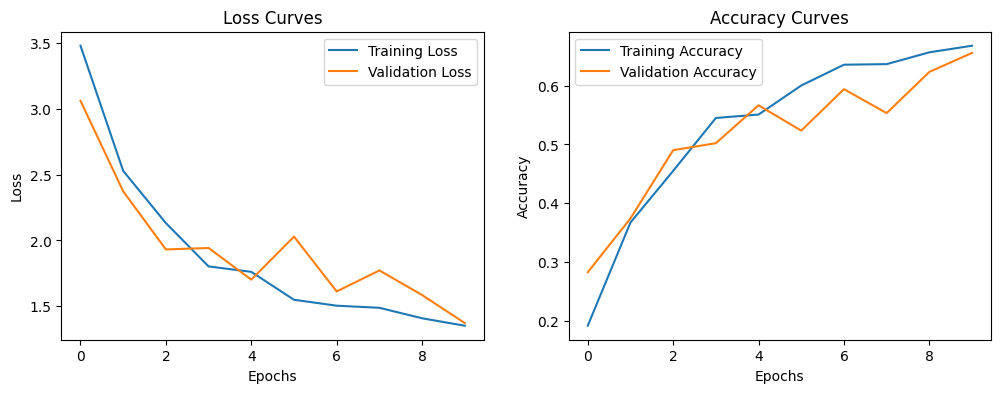

In [35]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plot_loss_curves(inception_history)

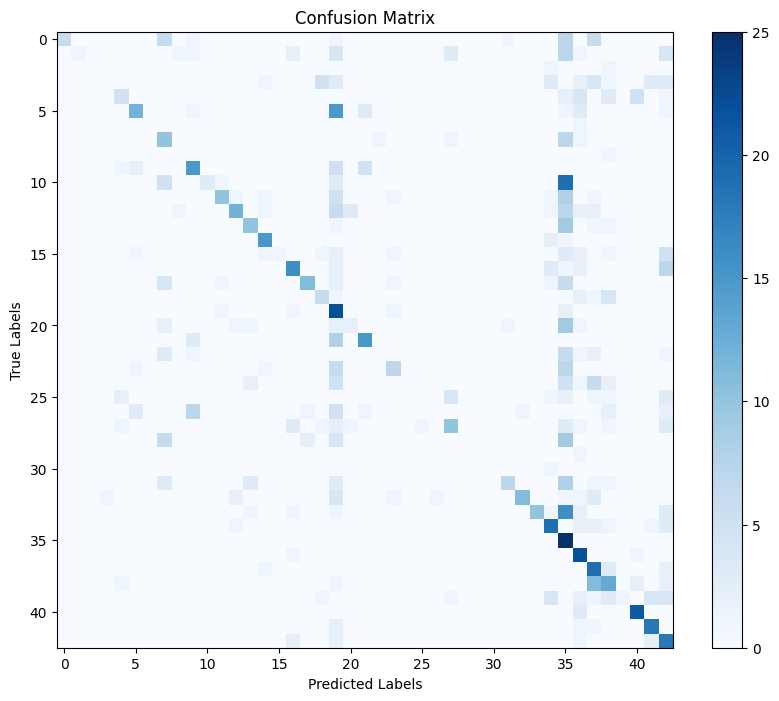

In [36]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, inception_predictions.argmax(axis=1))
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

### FITTING DEL MODELO

In [37]:
# Fine-Tuning (descongelar algunas capas superiores de InceptionV3)
inception_base.trainable = True
inception_fine_tune_at = 100  # Descongela las capas a partir de la capa 100

for layer in inception_base.layers[:inception_fine_tune_at]:
    layer.trainable = False

# Compilar nuevamente con una tasa de aprendizaje baja para el fine-tuning
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning
inception_history_fine = inception_model.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20241110-142309
Epoch 1/100
 4/69 ━━━━━━━━━━━━━━━━━━━━ 46s 719ms/step - accuracy: 0.1862 - loss: 3.2625

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.2806 - loss: 2.8985 - val_accuracy: 0.5273 - val_loss: 1.8275
Epoch 2/100
25/69 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.5552 - loss: 1.8153

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.5670 - loss: 1.7156 - val_accuracy: 0.5702 - val_loss: 1.5987
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 710ms/step - accuracy: 0.6686 - loss: 1.3419 - val_accuracy: 0.6992 - val_loss: 1.1412
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.7594 - loss: 1.0282 - val_accuracy: 0.7532 - val_loss: 1.0196
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 69s 772ms/step - accuracy: 0.7890 - loss: 0.8696 - val_accuracy: 0.7559 - val_loss: 0.9872
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.8386 - loss: 0.6883 - val_accuracy: 0.7957 - val_loss: 0.8622
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 693ms/step - accuracy: 0.8572 - loss: 0.6337 - val_accuracy: 0.8535 - val_loss: 0.6751
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.8894 - loss: 0.5110 - val_accuracy: 0.8383 - val_loss: 0.6583
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 759ms/step - accuracy: 0.9026 - loss: 0.4596 - val_accuracy

In [42]:
# Evaluación en el conjunto de prueba
inception_results = inception_model.evaluate(test_images, verbose=0)
print(f"InceptionV3 Test Loss: {inception_results[0]}")
print(f"InceptionV3 Test Accuracy: {inception_results[1] * 100:.2f}%")

# Generar Reporte de Clasificación
inception_predictions_fine = inception_model.predict(test_images, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning (InceptionV3):")
print(classification_report(test_images.classes, inception_predictions_fine.argmax(axis=1), target_names=test_images.class_indices.keys()))

InceptionV3 Test Loss: 1.3979625701904297
InceptionV3 Test Accuracy: 63.70%
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step
Reporte de Clasificación - Fine-Tuning (InceptionV3):
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.80      0.86      0.83        28
         Adho Mukha Vrksasana       0.53      0.42      0.47        24
                    Alanasana       0.00      0.00      0.00         2
                 Anjaneyasana       0.67      0.16      0.26        25
            Ardha Chandrasana       1.00      0.35      0.52        20
         Ardha Matsyendrasana       0.49      0.94      0.65        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       0.45      0.65      0.53        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.65      0.54      0.59        28
                     Bakasana       0.86      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


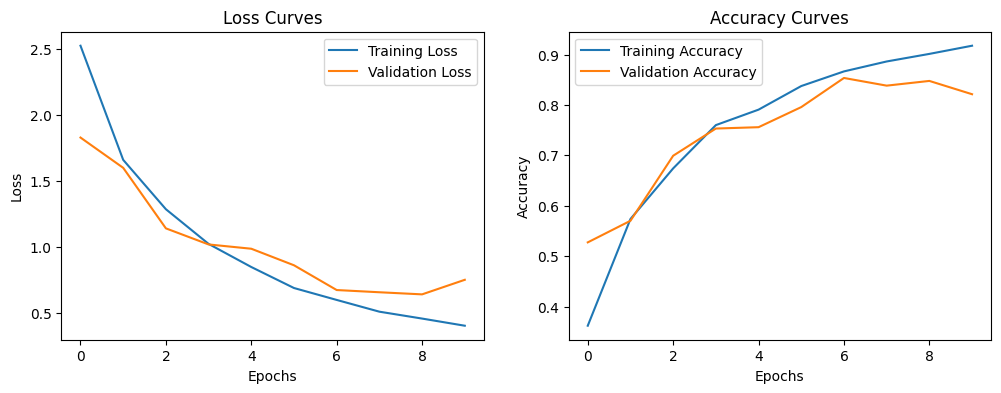

In [39]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plot_loss_curves(inception_history_fine)

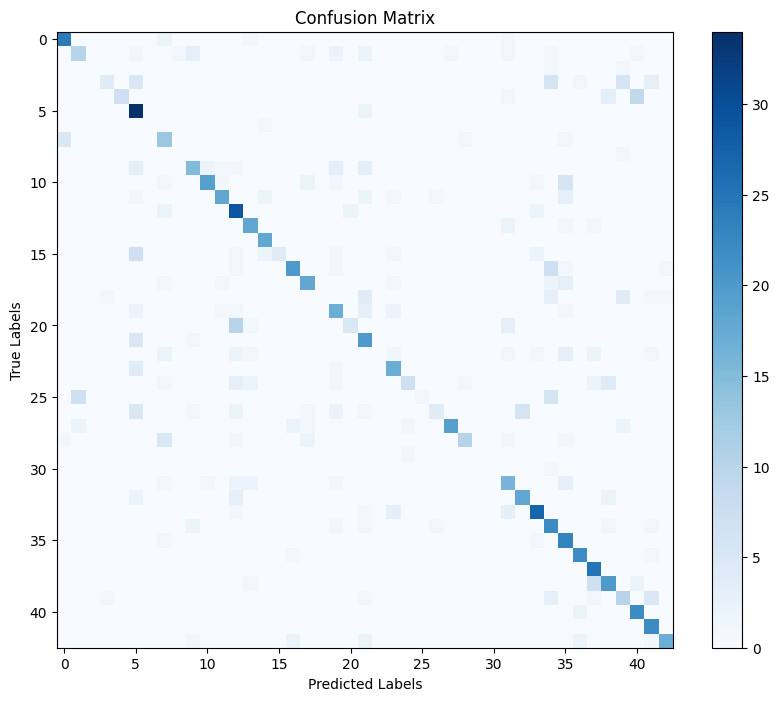

In [40]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, inception_predictions_fine.argmax(axis=1))
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

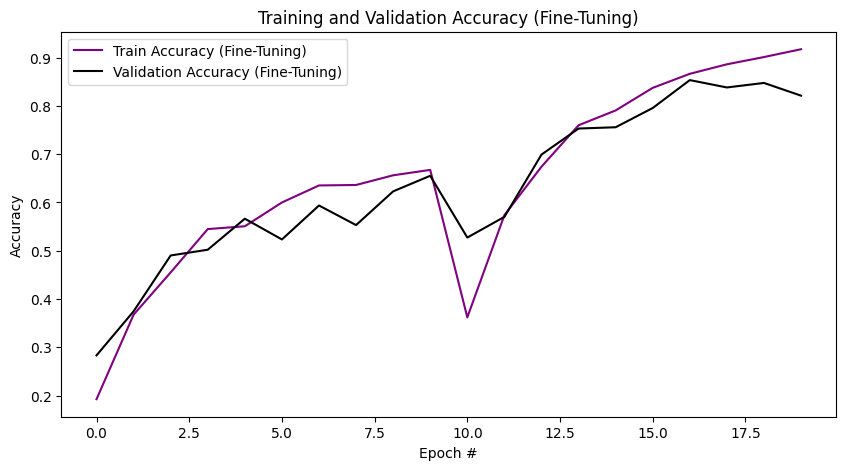

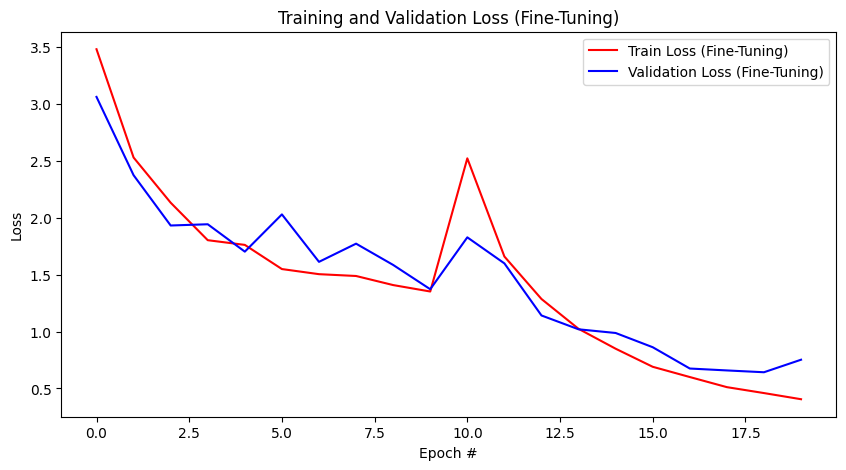

In [41]:
# Graficar precisión de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['accuracy'] + inception_history_fine.history['accuracy'], label="Train Accuracy (Fine-Tuning)", color='purple')
plt.plot(inception_history.history['val_accuracy'] + inception_history_fine.history['val_accuracy'], label="Validation Accuracy (Fine-Tuning)", color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(inception_history.history['loss'] + inception_history_fine.history['loss'], label="Train Loss (Fine-Tuning)", color='red')
plt.plot(inception_history.history['val_loss'] + inception_history_fine.history['val_loss'], label="Validation Loss (Fine-Tuning)", color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

# EVALUACIÓN DE LOS MODELOS

## COMPARACIÓN DE MODELOS PREENTRENADOS

Para este trabajo, usamos los modelos preentrenados MobileNetV2 y InceptionV3. En ambos casos, comenzamos sin la opción de reentrenar el modelo y luego relajamos esa restricción para evaluar mejoras.

MobileNet50 dio buenos resultados en su primera iteración sin reentrenamiento. Sus indicadores fueron de 0.89 para precisión, recall y F1. Sin embargo, el gráfico de pérdida mostró algo de sobreajuste, incluso habiendo incorporado L2 en el modelo. Luego, reentrenamos el modelo y, si bien los indicadores se mantuvieron, esta iteración sólo tomó 10 epochs en activar los *callbacks*. La matriz de confusión en ambos casos muestra una tendencia a la diagonal, lo que indica buena capacidad predictiva.

InceptionV3 no mostró tan buenos resultados en su primera iteración: sus indicadores fueron de 0.46 de precisión y 0.32 recall y F1. Sin embargo, sólo tomó 10 epochs en activar los *callbacks*, lo cual a nivel computacional es muy económico. Una vez que reentrenamos el modelo, los resultados mejoraron considerablemente: la precisión aumentó a 0.66, el recall a 0.64 y F1, a 0.61. La matriz de confusión también mejoró respecto a la iteración anterior. Sin embargo, no ubtuvimos mejores resultados que con MobileNet50.

## COMPARACIÓN ENTRE MODELO DESDE CERO Y MODELOS PREENTRENADOS

Una vez seleccionado nuestro mejor modelo preentrenado, lo comparamos con el modelo que entrenamos desde cero. Este último obtuvo indicadores de 0.74 en precisión y 0.72 en recall y F1. Además, su matriz de coincidencia muestra una tendencia hacia la línea diagonal, lo cual indica buena capacidad predictiva, y sus gráficos de pérdida no indican sobreajuste.

Sin embargo, este modelo demoró más tiempo en ejecutarse, necesitando 86 epochs para llegar a este resultado. En contraste, los modelos preentrenados requirieron como máximo la mitad de iteraciones. En efecto, los modelos preentrenados son buenas alternativas si es que no se tienen muchos datos de entrenamiento o recursos computacionales.

No obstante, la variabilidad entre los distintos modelos preentrenados es muy alta. Si bien MobileNet50 dio muy buenos resultados, el ajuste del modelo entrenado desde cero fue mejor que el de InceptionV3. Adicionalmente, en una primera instancia probamos el modelo ResNet50 que no dio buenos resultados. Todas estas pruebas también tienen un coste computacional y hubo instancias en que la memoria disponible no fue suficiente para ejecutar todo el código. Por lo tanto, el modelo entrenado desde cero puede ser más costoso que un modelo preentrenado, pero esto debe soperarse ante la necesidad de probar varios modelos para poder elegir uno.  